# INIZIO

In [ ]:
# delete warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# all imports
import numpy as np
import torch
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torchvision
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import joblib
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

# transforms
TRAIN_TRANSFORM = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])
TEST_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])
BATCH_SIZE = 32
CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
EPOCHS = 5

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=TRAIN_TRANSFORM)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=TEST_TRANSFORM)

X_train = np.array(train_dataset.data)
y_train = np.array(train_dataset.targets)


print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train = X_train / 255.0

X_train_flat = X_train.reshape(X_train.shape[0], -1)

print(f"X_train shape: {X_train_flat}")

X_test = np.array(test_dataset.data)
y_test = np.array(test_dataset.targets)

X_test = X_test / 255.0

X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"X_test shape: {X_test_flat.shape}")
print(f"y_test shape: {y_test.shape}")

# VISUALIZZAZIONE CLASSI

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(CLASSES)):
    # Find the index of the first image in the current class
    for j in range(len(y_train)):
        if y_train[j] == i:
            idx = j
            break

    # Get the first image in the current class
    image = X_train[idx]

    # Plot the image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[i])
    plt.axis('off')

plt.suptitle('Sample Images from Each Class')
plt.tight_layout()
plt.show()

# UTILS

In [2]:
def save_model(model, model_name):
    joblib.dump(model, f'{model_name}.pkl')
    print("Model saved!\n")


def load_model(model_name):
    model = joblib.load(f'{model_name}.pkl')

    return model


def test(model, images, labels):
    pred = model.predict(images)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')
    precision = precision_score(labels, pred, average='macro')
    recall = recall_score(labels, pred, average='macro')
    print(
        f'Test Accuracy: {acc*100:.2f}% | Test F1 score: {f1*100:.2f}% | Precision: {precision*100:.2f}% | Recall: {recall*100:.2f}%')
    return acc, f1, precision, recall

def train(pipeline, params, X, y, n_folds=5):
    k_fold = KFold(n_splits=n_folds)
    model = GridSearchCV(pipeline, params, cv=k_fold, scoring='accuracy', refit='accuracy', verbose=2)
    model.fit(X, y)

    print("Best parameters:", model.bestparams)
    print(f'Best score: {model.bestscore100:.2f}%\n')

    return model


def create_comparison(models, names, X_test, y_test):
    results = []
    for model, name in zip(models, names):
        acc, f1, precision, recall = test(model, X_test, y_test)
        results.append([name, 'Accuracy', acc])
        results.append([name, 'F1 Score', f1])
        results.append([name, 'Precision', precision])
        results.append([name, 'Recall', recall])
    results = pd.DataFrame(results, columns=['Model', 'Metric', 'Score'])

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='Score', hue='Metric', data=results)
    plt.title('Test Accuracy, F1 Score, Precision, and Recall')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return results


def show_confusion_matrix(model, images, labels):
    pred = model.predict(images)
    cm = confusion_matrix(labels, pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.title('Confusion Matrix')
    plt.show()


def show_first_n_predictions(model, images, labels, n=10):
    pred = model.predict(images)
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(32, 32, 3))
        plt.title(f'True: {CLASSES[labels[i]]}\nPred: {CLASSES[pred[i]]}')
        plt.axis('off')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def load_all_models(folder_path):
    for file_name in os.listdir(folder_path):
        if not file_name.endswith('.pkl'):
            continue
        if file_name.startswith('svm'): # svm requires 1.4.2+
            continue
        model_name = file_name.split('.')[0]
        model = load_model(f'{folder_path}/{model_name}')
        best_params = {
            key.replace("onevsoneclassifier__estimator__", "")
               .replace("onevsrestclassifier__estimator__", ""): value
            for key, value in model.best_params_.items()
        }
        best_score = f"{model.best_score_ * 100:.2f}%"
        print(f"> Model: {model_name}")
        print("\t> Best parameters:", best_params)
        print(f'\t> Best score: {best_score}\n')


load_all_models('/content/drive/MyDrive/Colab Notebooks/models')

# LOGISTIC REGRESSION 1vO

In [ ]:
log_reg_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
    OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
)

param_grid = {
    'onevsrestclassifier__estimator__C': [0.1, 1, 10, 100],
    'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
    'onevsrestclassifier__estimator__solver': ['liblinear', 'saga']
}

model = train(log_reg_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "log_reg_model")

# LOGISTIC REGRESSION 1v1

In [ ]:
log_reg_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
    OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state=42))

)

param_grid = {
    'onevsoneclassifier__estimator__C': [0.1, 1, 10, 100],
    'onevsoneclassifier__estimator__penalty': ['l1', 'l2'],
    'onevsoneclassifier__estimator__solver': ['liblinear', 'saga']
}

model = train(log_reg_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "log_reg_ovo_model")

# SVM 1vO

In [ ]:
svm_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', random_state=42),
    OneVsRestClassifier(SVC(random_state=42, kernel='rbf')))

param_grid = {
    'onevsrestclassifierestimatorC': [0.1, 1, 10, 100],
    'onevsrestclassifierestimatorgamma': [0.1, 0.01, 'scale', 'auto']
}

model = train(svm_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "svm_model")

# SVM 1v1

In [ ]:
svm_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', random_state=42),
    OneVsOneClassifier(SVC(random_state=42, kernel='rbf')))

param_grid = {
    'onevsoneclassifierestimatorC': [0.1, 1, 10, 100],
    'onevsoneclassifierestimatorgamma': [0.1, 0.01, 'scale', 'auto']
}

model = train(svm_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "svm_model")

# KNN 1VO

In [ ]:
knn_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
    OneVsRestClassifier(KNeighborsClassifier())
)

param_grid = {
    'onevsrestclassifier__estimator__n_neighbors': [5, 7, 9, 11],
    'onevsrestclassifier__estimator__weights': ['uniform', 'distance'],
    'onevsrestclassifier__estimator__metric': ['euclidean', 'minkowski'] #, 'manhattan']
}

model = train(knn_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "knn_model")

# KNN 1V1

In [ ]:
knn_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
    OneVsOneClassifier(KNeighborsClassifier())
)

param_grid = {
    'onevsoneclassifier__estimator__n_neighbors': [5, 7, 9, 11],
    'onevsoneclassifier__estimator__weights': ['uniform', 'distance'],
    'onevsoneclassifier__estimator__metric': ['euclidean', 'minkowski']
}

model = train(knn_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "knn_model")

# GNB 1vO

In [ ]:
nb_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', random_state=42),
    OneVsRestClassifier(GaussianNB())
)

param_grid = {
    'onevsrestclassifier__estimator__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}

k_fold = KFold(n_splits=5)

model = train(nb_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "gnb_model")

# GNB 1v1

In [ ]:
nb_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', random_state=42),
    OneVsOneClassifier(GaussianNB())
)

param_grid = {
    'onevsoneclassifier__estimator__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}

model = train(nb_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "gnb_ovo_model")

# RANDOM FOREST 1VO

In [ ]:
rfc_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', random_state=42),
    OneVsRestClassifier(RandomForestClassifier(random_state=42))
)

param_grid = {
    'onevsrestclassifier__estimator__n_estimators': [10, 50, 100],
    'onevsrestclassifier__estimator__max_features': ['sqrt', 'log2'],
    'onevsrestclassifier__estimator__min_samples_leaf': [1, 2, 4]
}

model = train(rfc_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "rfc_ovr_with_none_model")

# RANDOM FOREST 1V1

In [ ]:
rfc_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, svd_solver='full', random_state=42),
    OneVsOneClassifier(RandomForestClassifier(random_state=42))
)

param_grid = {
    'onevsoneclassifier__estimator__n_estimators': [10, 50, 100],
    'onevsoneclassifier__estimator__max_features': ['sqrt', 'log2'],
    'onevsoneclassifier__estimator__min_samples_leaf': [1, 2, 4]
}

model = train(rfc_pipeline, param_grid, X_train_flat, y_train)

In [ ]:
save_model(model, "rfc_ovo_with_none_model")

# COMPARISON

Test Accuracy: 40.77% | Test F1 score: 40.20% | Precision: 40.11% | Recall: 40.77%
Test Accuracy: 41.76% | Test F1 score: 41.43% | Precision: 41.32% | Recall: 41.76%
Test Accuracy: 30.12% | Test F1 score: 28.75% | Precision: 33.21% | Recall: 30.12%
Test Accuracy: 30.31% | Test F1 score: 29.07% | Precision: 32.72% | Recall: 30.31%
Test Accuracy: 38.29% | Test F1 score: 37.69% | Precision: 45.44% | Recall: 38.29%
Test Accuracy: 37.66% | Test F1 score: 37.09% | Precision: 45.35% | Recall: 37.66%
Test Accuracy: 46.53% | Test F1 score: 45.96% | Precision: 45.95% | Recall: 46.53%
Test Accuracy: 46.47% | Test F1 score: 45.95% | Precision: 46.57% | Recall: 46.47%


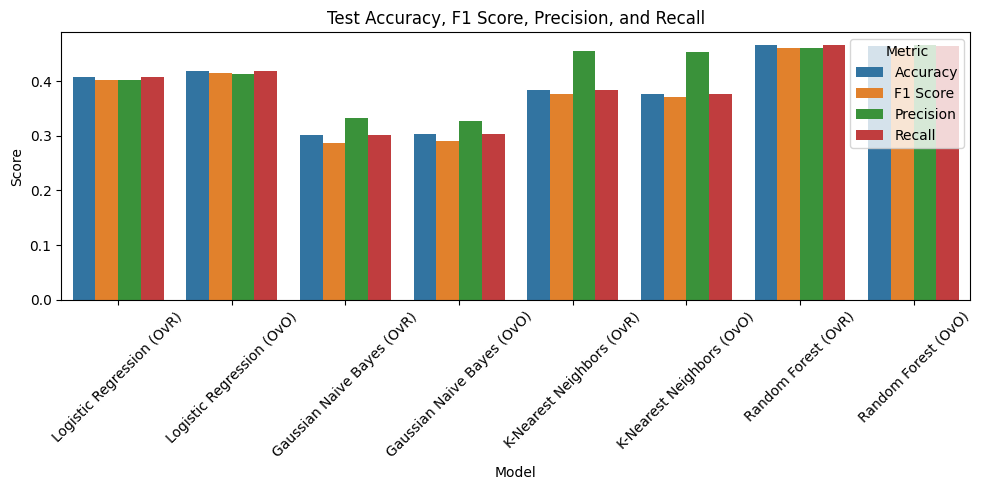

Logistic Regression (OvR)


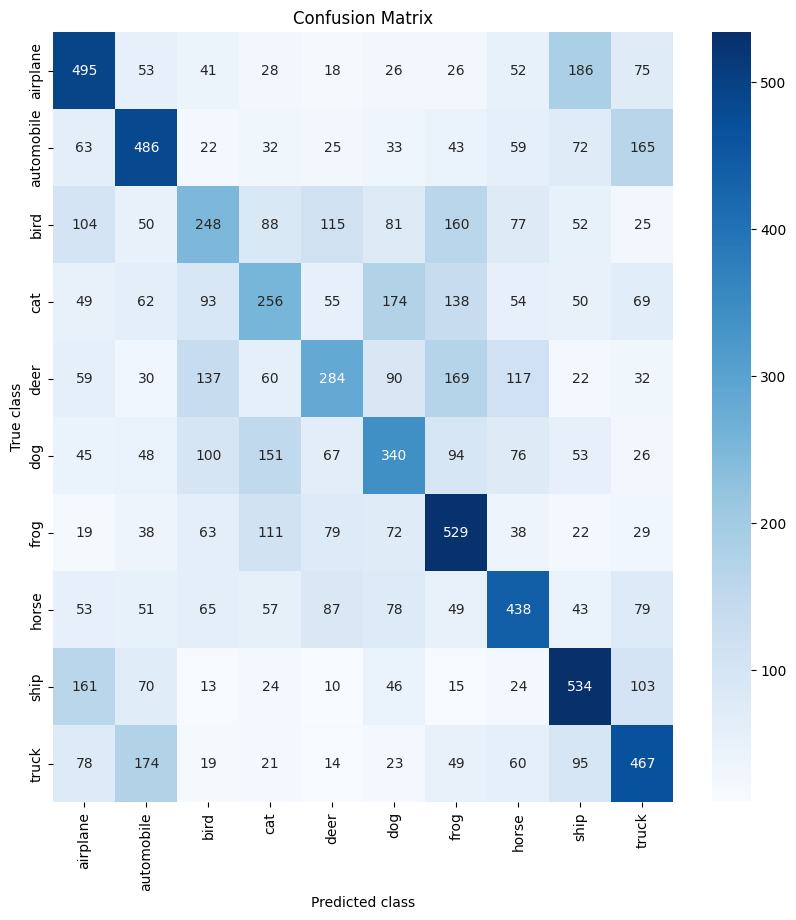

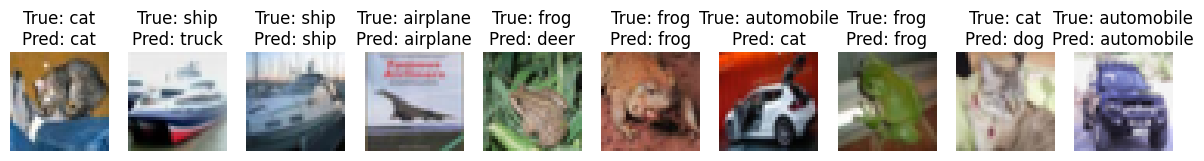

Logistic Regression (OvO)


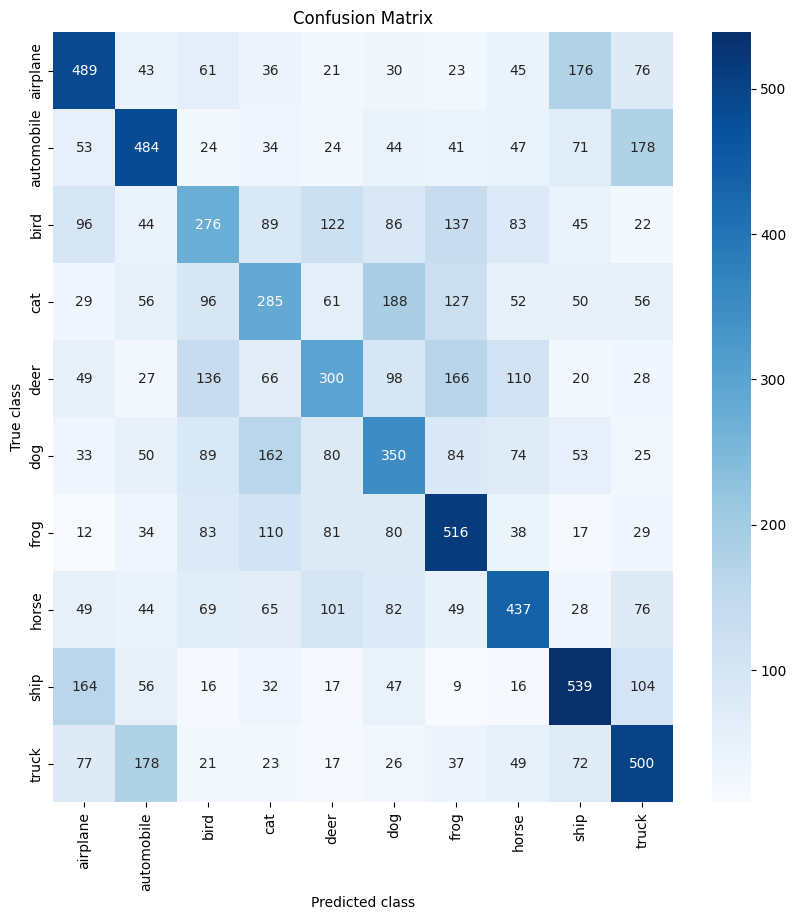

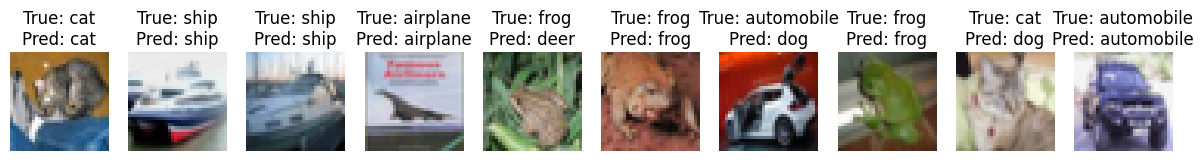

Gaussian Naive Bayes (OvR)


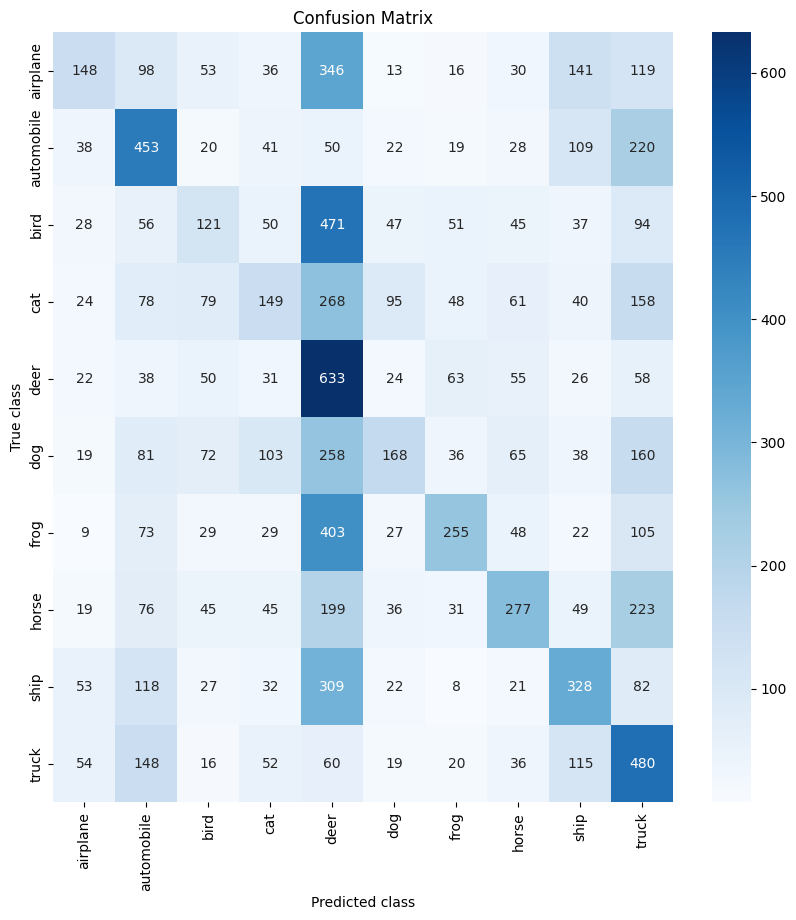

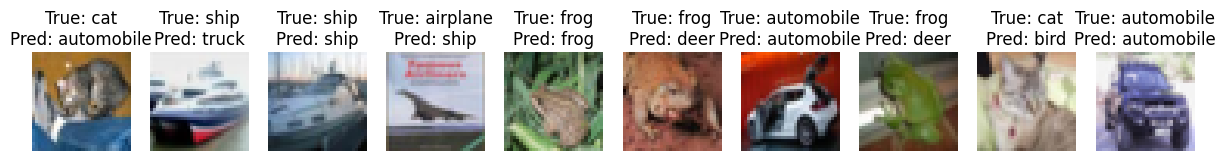

Gaussian Naive Bayes (OvO)


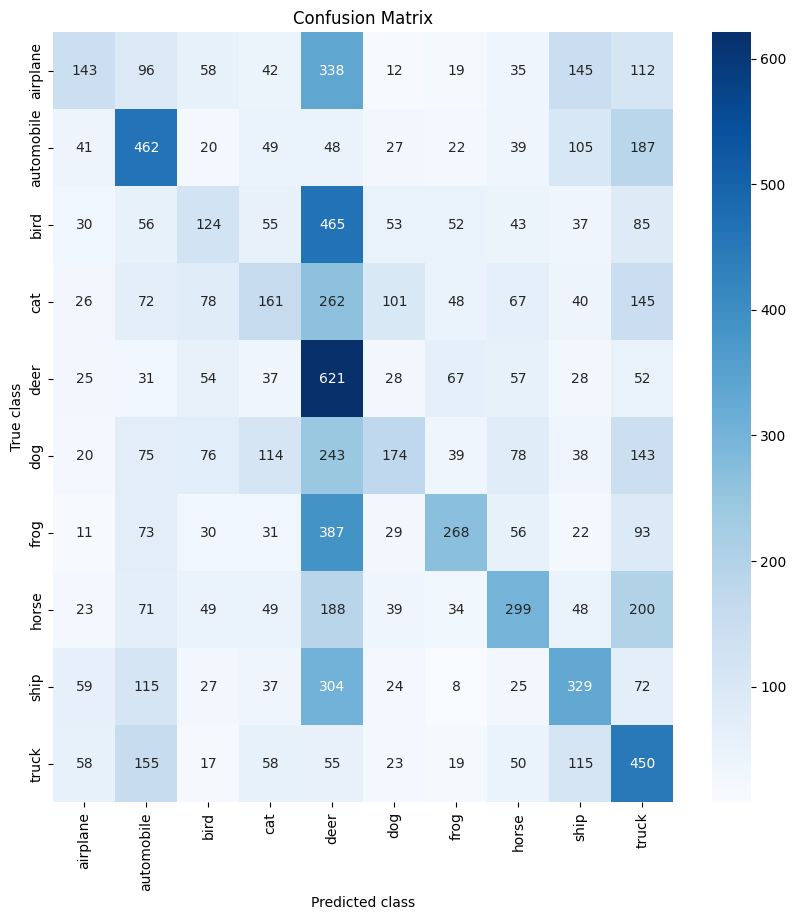

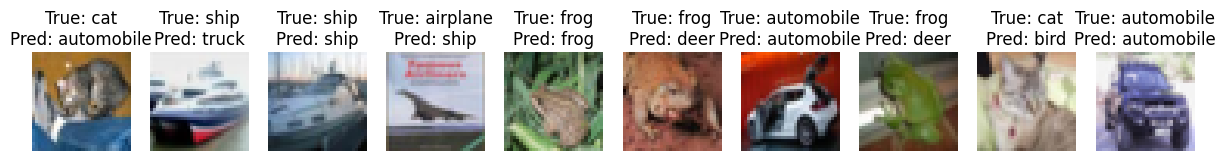

K-Nearest Neighbors (OvR)


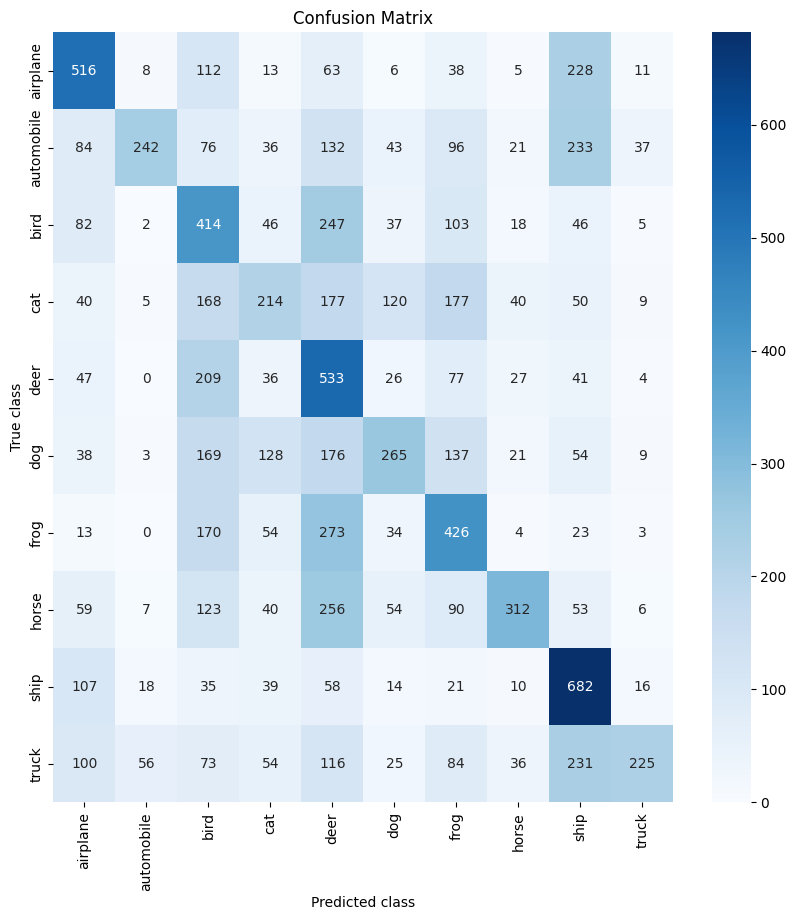

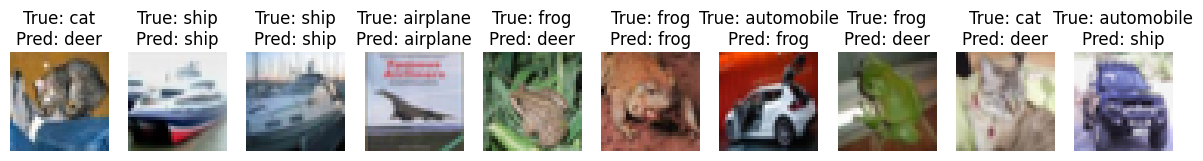

K-Nearest Neighbors (OvO)


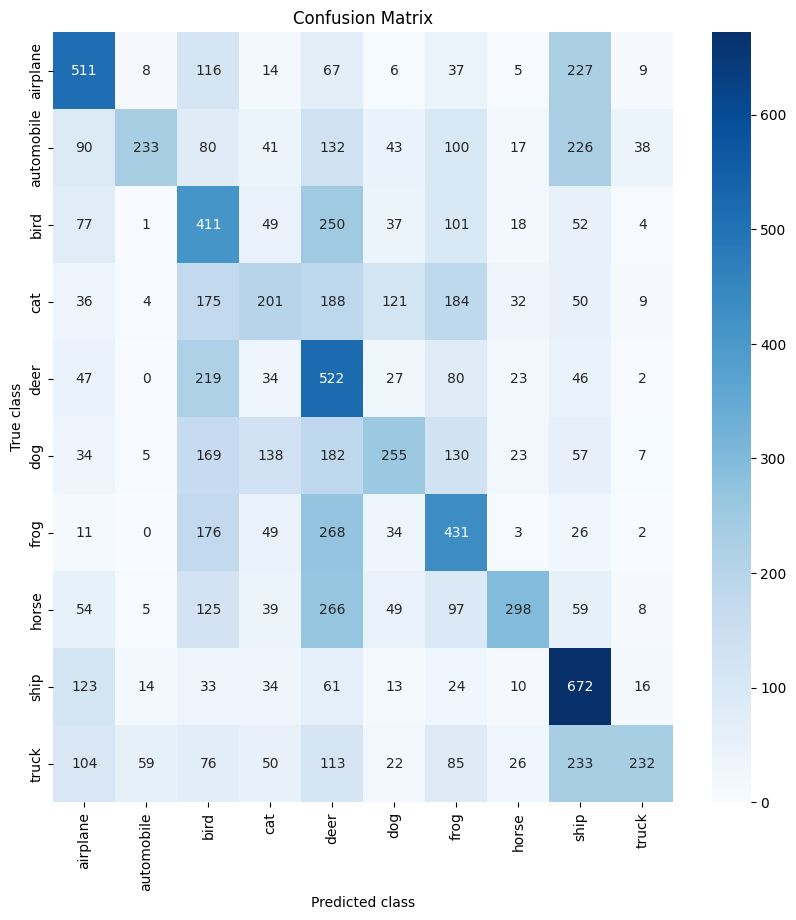

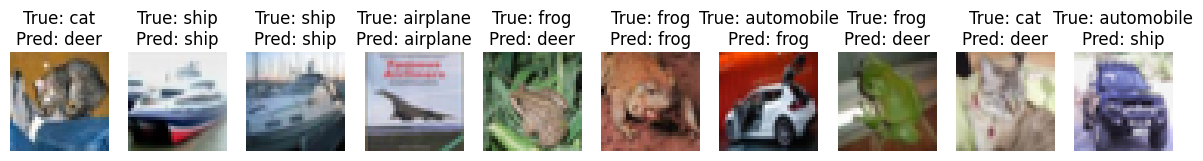

Random Forest (OvR)


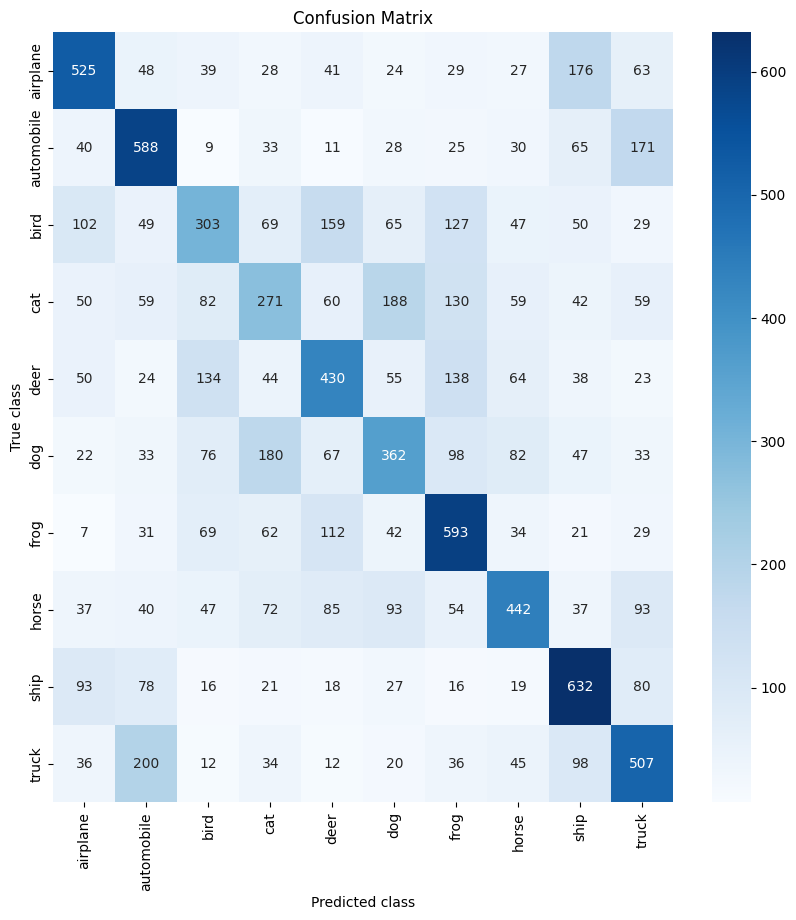

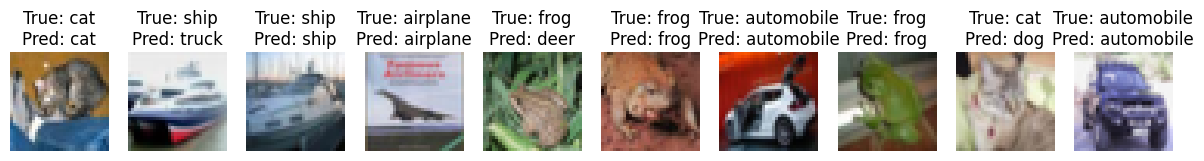

Random Forest (OvO)


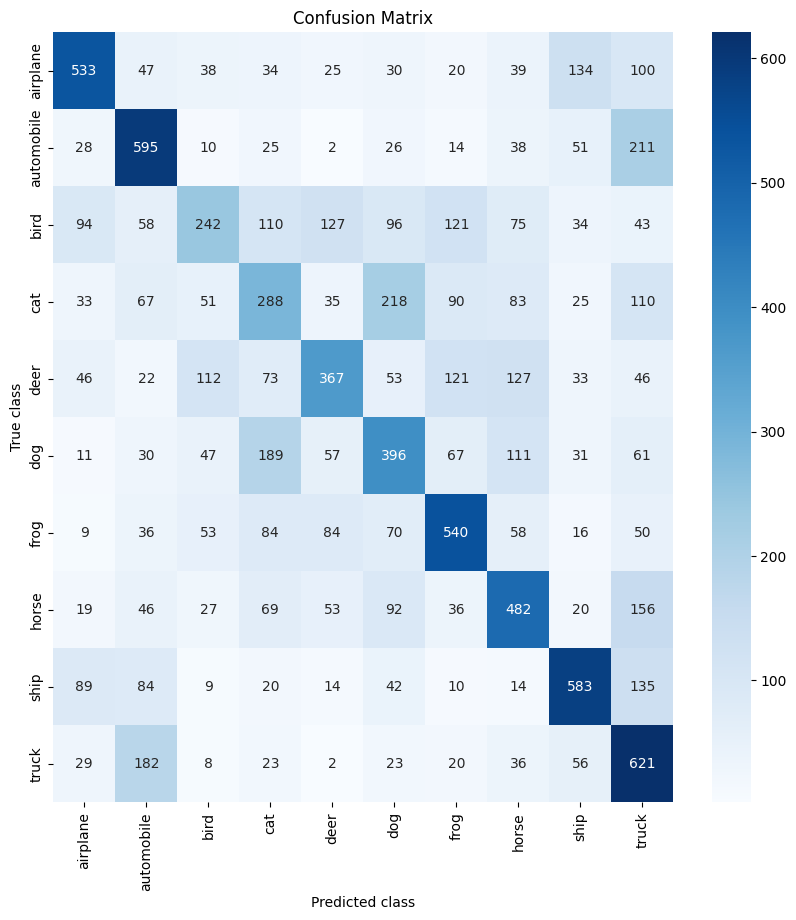

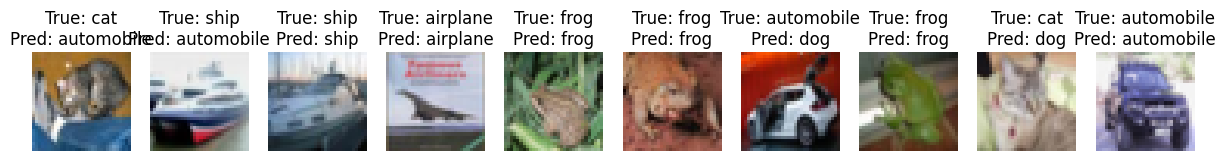

In [6]:
path = "/content/drive/MyDrive/Colab Notebooks/models/"

log_reg_ovr_model = load_model(path + "log_reg_ovr_model")
log_reg_ovo_model = load_model(path + "log_reg_ovo_model")
gnb_ovr_model = load_model(path + "gnb_ovr_model")
gnb_ovo_model = load_model(path + "gnb_ovo_model")
knn_ovr_model = load_model(path + "knn_ovr_model")
knn_ovo_model = load_model(path + "knn_ovo_model")
rfc_ovr_model = load_model(path + "rfc_ovr_model")
rfc_ovo_model = load_model(path + "rfc_ovo_model")
#svm_ovr_model = load_model(path + "svm_ovr_model")
#svm_ovo_model = load_model(path + "svm_ovo_model")

comparison = create_comparison(
    [
        log_reg_ovr_model,
        log_reg_ovo_model,
        gnb_ovr_model,
        gnb_ovo_model,
        knn_ovr_model,
        knn_ovo_model,
        rfc_ovr_model,
        rfc_ovo_model,
        #svm_ovr_model,
        #svm_ovo_model
    ],
    [
        "Logistic Regression (OvR)",
        "Logistic Regression (OvO)",
        "Gaussian Naive Bayes (OvR)",
        "Gaussian Naive Bayes (OvO)",
        "K-Nearest Neighbors (OvR)",
        "K-Nearest Neighbors (OvO)",
        "Random Forest (OvR)",
        "Random Forest (OvO)",
        #"Support Vector Machine (OvR)",
        #"Support Vector Machine (OvO)"
    ],
    X_test_flat,
    y_test
)

print("Logistic Regression (OvR)")
show_confusion_matrix(log_reg_ovr_model, X_test_flat, y_test)
show_first_n_predictions(log_reg_ovr_model, X_test_flat, y_test)

print("Logistic Regression (OvO)")
show_confusion_matrix(log_reg_ovo_model, X_test_flat, y_test)
show_first_n_predictions(log_reg_ovo_model, X_test_flat, y_test)

print("Gaussian Naive Bayes (OvR)")
show_confusion_matrix(gnb_ovr_model, X_test_flat, y_test)
show_first_n_predictions(gnb_ovr_model, X_test_flat, y_test)

print("Gaussian Naive Bayes (OvO)")
show_confusion_matrix(gnb_ovo_model, X_test_flat, y_test)
show_first_n_predictions(gnb_ovo_model, X_test_flat, y_test)

print("K-Nearest Neighbors (OvR)")
show_confusion_matrix(knn_ovr_model, X_test_flat, y_test)
show_first_n_predictions(knn_ovr_model, X_test_flat, y_test)

print("K-Nearest Neighbors (OvO)")
show_confusion_matrix(knn_ovo_model, X_test_flat, y_test)
show_first_n_predictions(knn_ovo_model, X_test_flat, y_test)

print("Random Forest (OvR)")
show_confusion_matrix(rfc_ovr_model, X_test_flat, y_test)
show_first_n_predictions(rfc_ovr_model, X_test_flat, y_test)

print("Random Forest (OvO)")
show_confusion_matrix(rfc_ovo_model, X_test_flat, y_test)
show_first_n_predictions(rfc_ovo_model, X_test_flat, y_test)

#print("Support Vector Machine (OvR)")
#show_confusion_matrix(svm_ovr_model, X_test_flat, y_test)
#show_first_n_predictions(svm_ovr_model, X_test_flat, y_test)

#print("Support Vector Machine (OvO)")
#show_confusion_matrix(svm_ovo_model, X_test_flat, y_test)
#show_first_n_predictions(svm_ovo_model, X_test_flat, y_test)

In [ ]:
!pip install scikit-learn==1.4.2 --upgrade

In [ ]:
!pip install scikit-learn-intelex

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/models/"

#log_reg_ovr_model = load_model(path + "log_reg_ovr_model")
#log_reg_ovo_model = load_model(path + "log_reg_ovo_model")
#gnb_ovr_model = load_model(path + "gnb_ovr_model")
#gnb_ovo_model = load_model(path + "gnb_ovo_model")
#knn_ovr_model = load_model(path + "knn_ovr_model")
#knn_ovo_model = load_model(path + "knn_ovo_model")
#rfc_ovr_model = load_model(path + "rfc_ovr_model")
#rfc_ovo_model = load_model(path + "rfc_ovo_model")
svm_ovr_model = load_model(path + "svm_ovr_model").best_estimator_
svm_ovo_model = load_model(path + "svm_ovo_model").best_estimator_

comparison = create_comparison(
    [
        #log_reg_ovr_model,
        #log_reg_ovo_model,
        #gnb_ovr_model,
        #gnb_ovo_model,
        #knn_ovr_model,
        #knn_ovo_model,
        #rfc_ovr_model,
        #rfc_ovo_model,
        svm_ovr_model,
        svm_ovo_model
    ],
    [
        #"Logistic Regression (OvR)",
        #"Logistic Regression (OvO)",
        #"Gaussian Naive Bayes (OvR)",
        #"Gaussian Naive Bayes (OvO)",
        #"K-Nearest Neighbors (OvR)",
        #"K-Nearest Neighbors (OvO)",
        #"Random Forest (OvR)",
        #"Random Forest (OvO)",
        "Support Vector Machine (OvR)",
        "Support Vector Machine (OvO)"
    ],
    X_test_flat,
    y_test
)

#print("Logistic Regression (OvR)")
#show_confusion_matrix(log_reg_ovr_model, X_test_flat, y_test)
#show_first_n_predictions(log_reg_ovr_model, X_test_flat, y_test)

#print("Logistic Regression (OvO)")
#show_confusion_matrix(log_reg_ovo_model, X_test_flat, y_test)
#show_first_n_predictions(log_reg_ovo_model, X_test_flat, y_test)

#print("Gaussian Naive Bayes (OvR)")
#show_confusion_matrix(gnb_ovr_model, X_test_flat, y_test)
#show_first_n_predictions(gnb_ovr_model, X_test_flat, y_test)

#print("Gaussian Naive Bayes (OvO)")
#show_confusion_matrix(gnb_ovo_model, X_test_flat, y_test)
#show_first_n_predictions(gnb_ovo_model, X_test_flat, y_test)

#print("K-Nearest Neighbors (OvR)")
#show_confusion_matrix(knn_ovr_model, X_test_flat, y_test)
#show_first_n_predictions(knn_ovr_model, X_test_flat, y_test)

#print("K-Nearest Neighbors (OvO)")
#show_confusion_matrix(knn_ovo_model, X_test_flat, y_test)
#show_first_n_predictions(knn_ovo_model, X_test_flat, y_test)

#print("Random Forest (OvR)")
#show_confusion_matrix(rfc_ovr_model, X_test_flat, y_test)
#show_first_n_predictions(rfc_ovr_model, X_test_flat, y_test)

#print("Random Forest (OvO)")
#show_confusion_matrix(rfc_ovo_model, X_test_flat, y_test)
#show_first_n_predictions(rfc_ovo_model, X_test_flat, y_test)

print("Support Vector Machine (OvR)")
show_confusion_matrix(svm_ovr_model, X_test_flat, y_test)
show_first_n_predictions(svm_ovr_model, X_test_flat, y_test)

print("Support Vector Machine (OvO)")
show_confusion_matrix(svm_ovo_model, X_test_flat, y_test)
show_first_n_predictions(svm_ovo_model, X_test_flat, y_test)